## This exploration tests [functorch](https://pytorch.org/blog/pytorch-1.11-released/)'s per example gradient computation capabilities.

We know that clipping gradients in DP-SGD introduces bias. 
The following code studies the impact of adding symmetric pre-clipping noise on parameter recovery, suggested in Section 5 of [this](https://arxiv.org/pdf/2006.15429.pdf) paper  on a toy logistic regression model.
 To isolate the effect of pre-clipping noise, we don't add DP noise.


In [1]:
%load_ext tensorboard

%tensorboard --logdir runs/


In [3]:
import pandas as pd
import numpy as np
import shutil


import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as lreg

from tqdm import tqdm

from functorch import make_functional, vmap, grad
from functorch import vmap, grad_and_value
from functorch import make_functional

from torch.utils.tensorboard import SummaryWriter


default_seed = 1234

torch.manual_seed(default_seed)
np.random.seed(default_seed)
N = 20000


shutil.rmtree("runs/",ignore_errors=True) 


'''
True parameter we would like to recover.
'''
d =3

theta = np.array([-0.1,1.0,-3.0])        

def create_un_separable_dataset(N,d):
    ####
    ## Not guaranteed to be linearly seperable.
    ###
    def sigmoid(x):
        return 1.0/(1.0+np.exp(-x))   
    
    Sigma =datasets.make_spd_matrix(d,random_state = default_seed)
    inputs = np.random.multivariate_normal(np.ones(d), Sigma, int(N))
    labels = np.random.binomial(1.0, sigmoid(inputs.dot(theta)))
    return torch.Tensor(inputs),torch.Tensor(labels)



class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim,bias=False) ## Setting model intercept to 0.
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))
    

inputs,labels = create_un_separable_dataset(N,d)

X_train, X_test, y_train,  y_test = train_test_split( inputs, labels, test_size=0.2, random_state=default_seed)

C = 0.1 ## clipping threshold
epochs = 10000
learning_rate = 0.01
N = X_train.shape[0]
batch_size = int(np.sqrt(N))
theta = torch.tensor(theta)
df_dist_opt = pd.DataFrame(np.zeros(shape=(8,epochs)),columns=range(epochs))
df_dist_opt.index = [0.1,0.5,1.0,2.0,5.0,10.,20.,100.]

'''
The variable k controls the variance of the pre-clipping noise we are adding.
'''
for k in [0.1,0.5,1.0,2.0,5.0,10.,20.,100.]:
    
    model_lr  = LogisticRegression(d,1)    
    model_init = torch.zeros(d)

    with torch.no_grad():        
        for param in model_lr.parameters():
            param.copy_(model_init)

    criterion = torch.nn.BCELoss()


    optimizer_batch   = torch.optim.SGD(model_lr.parameters(), lr=learning_rate) 
    writer = SummaryWriter()

    one = torch.ones(1)

    def compute_norm_and_clip_grads(grad):
        return (grad*torch.minimum(one,C/grad.norm(2,dim=-1)))    
   
    def get_sample_grads(x,y,model):    
        def compute_loss_and_output(weights, x, obesered_y):
            predicted_y = func_model(weights, x).squeeze()
            loss = criterion(predicted_y, obesered_y)
            return loss, predicted_y

        func_model, weights = make_functional(model)
        grads_loss_output = grad_and_value(compute_loss_and_output, has_aux=True)    
        ## using vmap from functorch for fast per example gradient calculations.
        sample_grads, (sample_loss, output) = vmap(grads_loss_output, (None, 0, 0))(weights, x, y)   
        return sample_grads, (sample_loss, output)

    param_list = torch.zeros((epochs,d))
    
    for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
        optimizer_batch.zero_grad()        

        batch_indices=torch.randint(0,N, (batch_size,))
        sample_grads, (sample_loss, output)=get_sample_grads(X_train[batch_indices],y_train[batch_indices],model_lr)        
        writer.add_scalar("training loss:", sample_loss.mean(), epoch)
        for param in model_lr.parameters():
            weights = param
        
        writer.add_scalar("distance from true theta:",torch.linalg.norm(weights- theta,dim=-1),epoch)

        df_dist_opt.loc[k][epoch] = torch.linalg.norm(weights- theta,dim=-1)
        sample_grads= sample_grads[0]
        
        '''
        Adding zero mean Gaussian noise to the gradients.
        '''
        if k >0.0:
            sample_grads+= k*torch.randn((batch_size,1,d,))
            
        '''
        Clipping grads with vmap.
        '''
        clipped_grads = vmap(compute_norm_and_clip_grads)(sample_grads)    

        for name, param in model_lr.named_parameters():
            param.grad = clipped_grads.sum(0)
        optimizer_batch.step()    

        
    for param in model_lr.parameters():
        print("pre-clipping noise added",param)
    print(theta)


Training Epochs: 100%|███████████████████████████████████████████| 10000/10000 [00:21<00:00, 461.93it/s]


pre-clipping noise added Parameter containing:
tensor([[-0.4170,  2.0524, -6.6052]], requires_grad=True)
tensor([-0.1000,  1.0000, -3.0000], dtype=torch.float64)


Training Epochs: 100%|███████████████████████████████████████████| 10000/10000 [00:17<00:00, 576.10it/s]


pre-clipping noise added Parameter containing:
tensor([[-0.2030,  1.3190, -4.0252]], requires_grad=True)
tensor([-0.1000,  1.0000, -3.0000], dtype=torch.float64)


Training Epochs: 100%|███████████████████████████████████████████| 10000/10000 [00:17<00:00, 573.68it/s]


pre-clipping noise added Parameter containing:
tensor([[-0.2123,  1.0611, -3.2348]], requires_grad=True)
tensor([-0.1000,  1.0000, -3.0000], dtype=torch.float64)


Training Epochs: 100%|███████████████████████████████████████████| 10000/10000 [00:17<00:00, 557.90it/s]


pre-clipping noise added Parameter containing:
tensor([[-0.1738,  1.2352, -3.3488]], requires_grad=True)
tensor([-0.1000,  1.0000, -3.0000], dtype=torch.float64)


Training Epochs: 100%|███████████████████████████████████████████| 10000/10000 [00:17<00:00, 562.81it/s]


pre-clipping noise added Parameter containing:
tensor([[-0.0637,  0.9667, -2.9643]], requires_grad=True)
tensor([-0.1000,  1.0000, -3.0000], dtype=torch.float64)


Training Epochs: 100%|███████████████████████████████████████████| 10000/10000 [00:18<00:00, 547.18it/s]


pre-clipping noise added Parameter containing:
tensor([[-0.3752,  0.8331, -2.5536]], requires_grad=True)
tensor([-0.1000,  1.0000, -3.0000], dtype=torch.float64)


Training Epochs: 100%|███████████████████████████████████████████| 10000/10000 [00:19<00:00, 524.29it/s]


pre-clipping noise added Parameter containing:
tensor([[-0.2782,  0.6403, -2.1122]], requires_grad=True)
tensor([-0.1000,  1.0000, -3.0000], dtype=torch.float64)


Training Epochs: 100%|███████████████████████████████████████████| 10000/10000 [00:19<00:00, 520.01it/s]

pre-clipping noise added Parameter containing:
tensor([[-0.1140, -0.0578, -1.1992]], requires_grad=True)
tensor([-0.1000,  1.0000, -3.0000], dtype=torch.float64)


In [4]:
%load_ext tensorboard

%tensorboard --logdir runs/


In the tensorboard, click on the "Wall" axis to compare the training loss and distance of the recovered parameter from the true theta.
We observe that increasing k reduce the training error and improves the accuracy of estimated parameter initially. On the other hand, too large noise scales produce the opposite effect. 

Text(0.5, 1.0, 'Distance from the true theta as a function of epochs and k.')

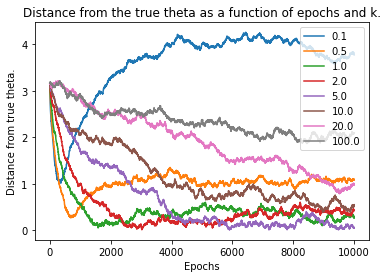

In [4]:

df_dist_opt.T.plot()
plt.xlabel("Epochs")
plt.ylabel("Distance from true theta.")
plt.title("Distance from the true theta as a function of epochs and k.")